In [1]:
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Data Preparation

In [2]:
df = pd.read_csv("hotel_bookings.csv")
df.head()

Y = df['hotel']
X = df.drop('hotel', axis=1)

categorical_columns = [col for col in X.columns if X[col].dtype == 'O']
X[categorical_columns]

,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date
0,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,2015-07-01
1,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,2015-07-01
2,July,BB,GBR,Direct,Direct,A,C,No Deposit,Transient,Check-Out,2015-07-02
3,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Check-Out,2015-07-02
4,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...
119385,August,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Check-Out,2017-09-06
119386,August,BB,FRA,Online TA,TA/TO,E,E,No Deposit,Transient,Check-Out,2017-09-07
119387,August,BB,DEU,Online TA,TA/TO,D,D,No Deposit,Transient,Check-Out,2017-09-07
119388,August,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2017-09-07


In [3]:
X['reservation_status_date'] = pd.to_datetime(X['reservation_status_date'])

X['reservation_year'] = X['reservation_status_date'].dt.year
X['reservation_month'] = X['reservation_status_date'].dt.month
X['reservation_day'] = X['reservation_status_date'].dt.day

X.drop(['reservation_status_date'] , axis = 1, inplace = True)
categorical_columns.remove('reservation_status_date')

In [4]:
X

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_year,reservation_month,reservation_day
0,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015,7,1
1,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015,7,1
2,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015,7,2
3,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015,7,2
4,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017,9,6
119386,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017,9,7
119387,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017,9,7
119388,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017,9,7


In [5]:
frames = [X]

for category in categorical_columns:
  frames.append(pd.get_dummies(X[category], prefix = category))

X = pd.concat(frames, axis = 1)
X = X.drop(categorical_columns, axis=1)

#### Filling missing values with 0

In [6]:
for column in X.columns:
  X[column] = X[column].fillna(value = 0)

X

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_year,reservation_month,reservation_day,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,...,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,reservation_status_Canceled,reservation_status_Check-Out,reservation_status_No-Show
0,0,342,2015,27,1,0,0,2,0.0,0,0,0,0,3,0.0,0.0,0,0.00,0,0,2015,7,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
1,0,737,2015,27,1,0,0,2,0.0,0,0,0,0,4,0.0,0.0,0,0.00,0,0,2015,7,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
2,0,7,2015,27,1,0,1,1,0.0,0,0,0,0,0,0.0,0.0,0,75.00,0,0,2015,7,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
3,0,13,2015,27,1,0,1,1,0.0,0,0,0,0,0,304.0,0.0,0,75.00,0,0,2015,7,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
4,0,14,2015,27,1,0,2,2,0.0,0,0,0,0,0,240.0,0.0,0,98.00,0,1,2015,7,3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,35,30,2,5,2,0.0,0,0,0,0,0,394.0,0.0,0,96.14,0,0,2017,9,6,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
119386,0,102,2017,35,31,2,5,3,0.0,0,0,0,0,0,9.0,0.0,0,225.43,0,2,2017,9,7,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
119387,0,34,2017,35,31,2,5,2,0.0,0,0,0,0,0,9.0,0.0,0,157.71,0,4,2017,9,7,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
119388,0,109,2017,35,31,2,5,2,0.0,0,0,0,0,0,89.0,0.0,0,104.40,0,0,2017,9,7,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0


#### Normalization

In [7]:
X=(X - np.min(X))/(np.max(X)-np.min(X))

In [8]:
X

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_year,reservation_month,reservation_day,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,...,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,reservation_status_Canceled,reservation_status_Check-Out,reservation_status_No-Show
0,0.0,0.464043,0.0,0.500000,0.000000,0.000000,0.00,0.036364,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.001180,0.0,0.0,0.333333,0.545455,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.000000,0.0,0.500000,0.000000,0.000000,0.00,0.036364,0.0,0.0,0.0,0.0,0.0,0.190476,0.000000,0.0,0.0,0.001180,0.0,0.0,0.333333,0.545455,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.009498,0.0,0.500000,0.000000,0.000000,0.02,0.018182,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.015053,0.0,0.0,0.333333,0.545455,0.033333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.017639,0.0,0.500000,0.000000,0.000000,0.02,0.018182,0.0,0.0,0.0,0.0,0.0,0.000000,0.568224,0.0,0.0,0.015053,0.0,0.0,0.333333,0.545455,0.033333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.018996,0.0,0.500000,0.000000,0.000000,0.04,0.036364,0.0,0.0,0.0,0.0,0.0,0.000000,0.448598,0.0,0.0,0.019307,0.0,0.2,0.333333,0.545455,0.066667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0.0,0.031208,1.0,0.653846,0.966667,0.105263,0.10,0.036364,0.0,

#### Preparing labels

In [9]:
Y = Y.replace('Resort Hotel', 0)
Y = Y.replace('City Hotel', 1)

Y = to_categorical(Y) # ANN expects labels as one-hot encoding format
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=10)

# ANN

In [11]:
model = Sequential()
model.add(Dense(100, activation = 'relu', input_shape = (262, )))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(2, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 15)

Epoch 1/15
2612/2612 [==============================] - 14s 5ms/step - loss: 0.1783 - accuracy: 0.9252 - val_loss: 0.1316 - val_accuracy: 0.9463
Epoch 2/15
2612/2612 [==============================] - 9s 3ms/step - loss: 0.1214 - accuracy: 0.9500 - val_loss: 0.1167 - val_accuracy: 0.9530
Epoch 3/15
2612/2612 [==============================] - 7s 3ms/step - loss: 0.1049 - accuracy: 0.9572 - val_loss: 0.1049 - val_accuracy: 0.9568
Epoch 4/15
2612/2612 [==============================] - 10s 4ms/step - loss: 0.0942 - accuracy: 0.9617 - val_loss: 0.0962 - val_accuracy: 0.9609
Epoch 5/15
2612/2612 [==============================] - 6s 2ms/step - loss: 0.0867 - accuracy: 0.9643 - val_loss: 0.0918 - val_accuracy: 0.9642
Epoch 6/15
2612/2612 [==============================] - 6s 2ms/step - loss: 0.0787 - accuracy: 0.9685 - val_loss: 0.0900 - val_accuracy: 0.9639
Epoch 7/15
2612/2612 [==============================] - 6s 2ms/step - loss: 0.0730 - accuracy: 0.9704 - val_loss: 0.0873 - val_accurac

Text(0, 0.5, 'Validation Loss')

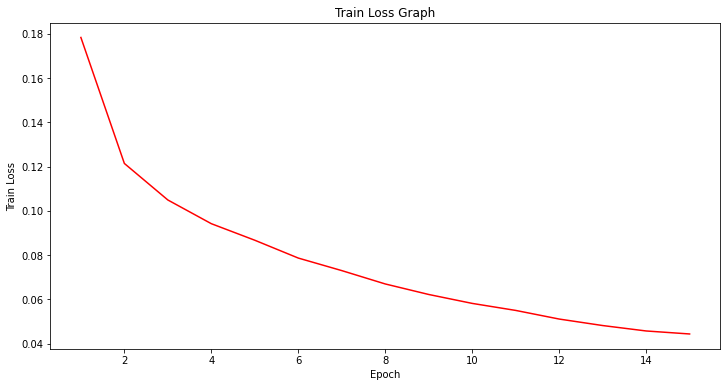

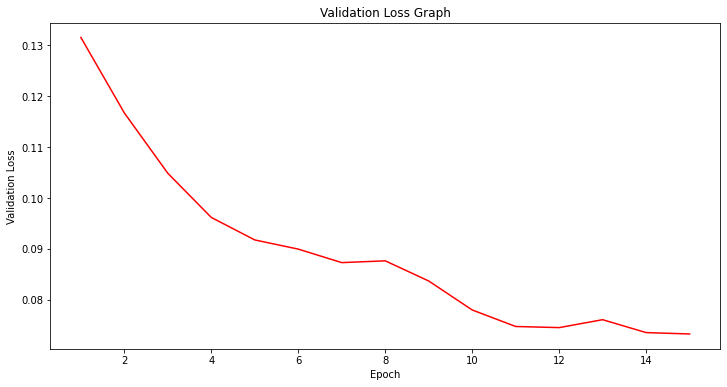

In [12]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(range(1, 16), train_loss, color='red', markersize=1)
plt.title('Train Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')

plt.figure(figsize=(12, 6))
plt.plot(range(1, 16), val_loss, color='red', markersize=1)
plt.title('Validation Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')

Text(0, 0.5, 'Validation Accuracy')

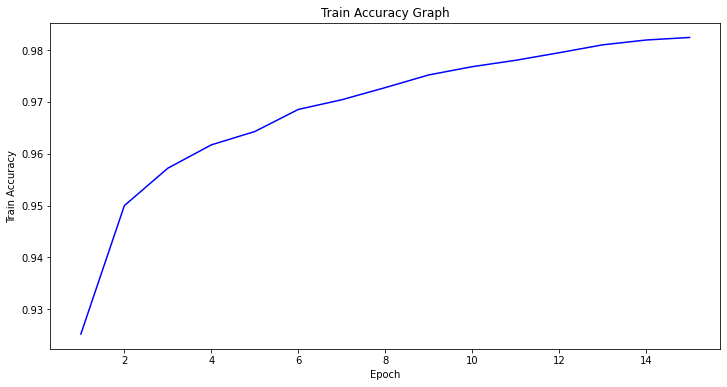

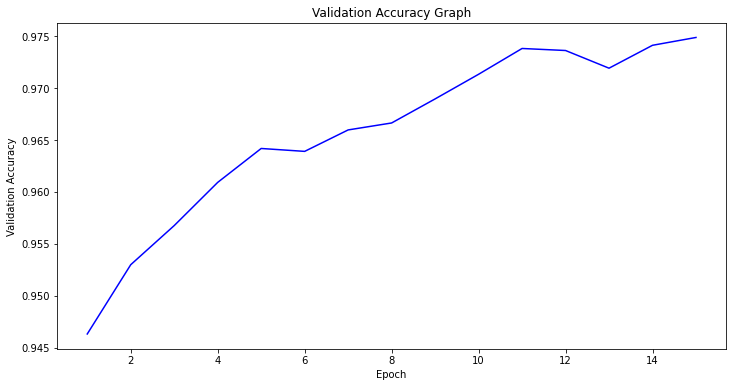

In [13]:
train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy'] 

plt.figure(figsize=(12, 6))
plt.plot(range(1, 16), train_acc, color='blue', markersize=1)
plt.title('Train Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')

plt.figure(figsize=(12, 6))
plt.plot(range(1, 16), val_acc, color='blue', markersize=1)
plt.title('Validation Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')

In [14]:
acc_ann = model.evaluate(X_test, y_test)[1]

print(f'Accuracy of model is {acc_ann}')

1120/1120 [==============================] - 1s 1ms/step - loss: 0.0733 - accuracy: 0.9749
Accuracy of model is 0.9748722910881042


# Precision, Recall and F-measure Analysis

In [15]:
def precision(tp, fp):
    return tp / (tp + fp)

def recall_sensitivity(tp, fn):
    return tp / (tp + fn)

def f1_score(tp, fp, fn):
    return 2 * tp / (2 * tp + fp + fn)

In [16]:
ann_predict = model.predict(X_test)
y_pred_classes = np.argmax(ann_predict, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

ann_cm = confusion_matrix(y_true, y_pred_classes) 
tn, fp, fn, tp = ann_cm.flatten()

print(f"Precision of ANN: {precision(tp, fp)}")
print(f"Recall Sensitivity of ANN: {recall_sensitivity(tp, fn)}")
print(f"F1-Score of ANN: {f1_score(tp, fp, fn)}")

Precision of ANN: 0.9820039524029769
Recall Sensitivity of ANN: 0.9820039524029769
F1-Score of ANN: 0.9810964083175804


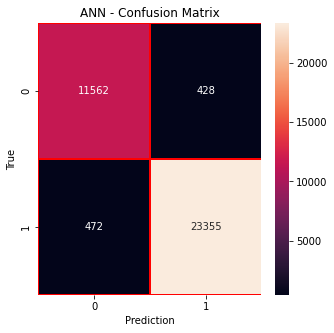

In [17]:
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(ann_cm, annot = True, linewidths=0.5, linecolor="red", fmt = ".0f", ax=ax)
plt.xlabel("Prediction")
plt.ylabel("True")
plt.title("ANN - Confusion Matrix")
plt.show()